In [1]:
import glob, sys
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import simps
import pyccl as ccl
from clmm import Cosmology
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

In [2]:
%load_ext autoreload
%autoreload 2
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_COUNT_modeling_richness_mass_relation as rm_relation
import CL_MASS_cluster_mass as cl_mass
import CL_COUNT_cluster_abundance as cl_count
import CL_LENSING_cluster_lensing as cl_lensing

# Hyper-parameters
## Hyper-parameters (non-cosmo)

In [3]:
#cosmology
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
#halo model
massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo, mass_def=massdef)

## Hyper-parameters (non-cosmo)

In [4]:
#purity
a_nc, b_nc, a_rc, b_rc = np.log(10)*0.8612, np.log(10)*0.3527, 2.2183, -0.6592
theta_purity = [a_nc, b_nc, a_rc, b_rc]
#completeness
a_nc, b_nc, a_mc, b_mc = 1.1321, 0.7751, 13.31, 0.2025
theta_completeness = [a_nc, b_nc, a_mc, b_mc]
#rm_relation
log10m0, z0 = np.log10(10**14.2), .4
proxy_mu0, proxy_muz, proxy_mulog10m =  3.091, 0, 1.05*np.log(10)
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  0.594, 0., 0.026*np.log(10)
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]

# Purity

In [5]:
richness_grid = np.logspace(np.log10(2), np.log10(500), 300)
logm_grid = np.linspace(11, 16, 301)
z_grid = np.linspace(.1, 1, 302)

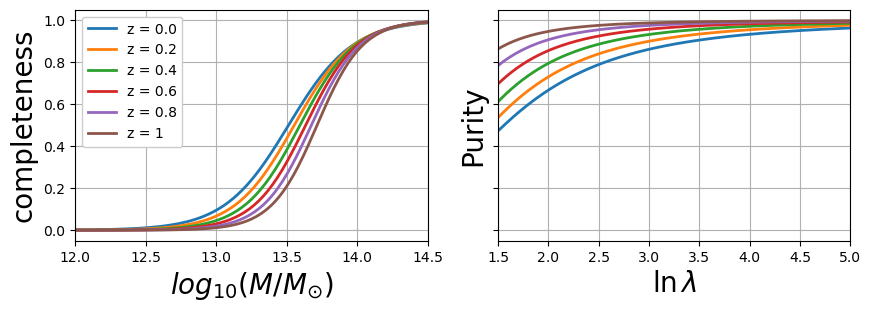

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
for z in [0., 0.2, 0.4, .6, .8, 1]:
    ax[1].plot(np.log(richness_grid), pur.purity(richness_grid, z, theta_purity), linewidth=2)
    ax[1].set_xlabel(r'$\ln \lambda$', fontsize=20)
    ax[1].set_ylabel('Purity', fontsize=20)
    ax[1].grid(True)
    ax[1].set_xlim(1.5, 5)
    ax[0].plot(logm_grid, comp.completeness(logm_grid, z, theta_completeness), linewidth=2, label = f'z = {z}')
    ax[0].set_xlabel(r'$log_{10}(M/M_{\odot})$', fontsize=20)
    ax[0].set_ylabel('completeness', fontsize=20)
    ax[0].set_xlim(12, 14.5)
    ax[0].grid(True)
    ax[0].legend(framealpha=1)
plt.savefig('Purity_completeness.png', bbox_inches='tight', dpi=300)

# Completeness

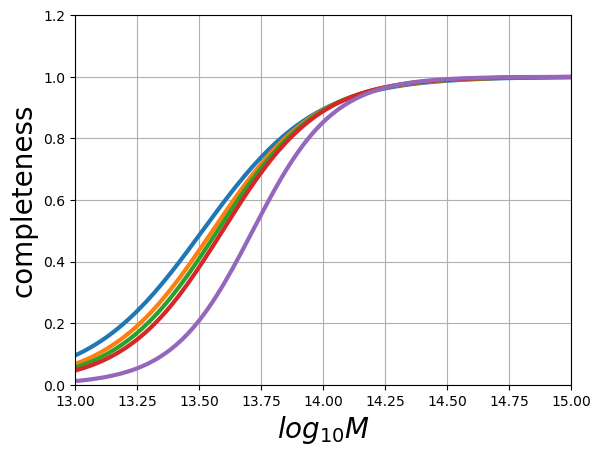

In [7]:
for z in [0, 0.2, 0.3, 0.4,1]:
    plt.plot(logm_grid, comp.completeness(logm_grid, z, theta_completeness), linewidth=3)
plt.xlabel(r'$log_{10}M$', fontsize=20)
plt.ylabel('completeness', fontsize=20)
plt.ylim(0, 1.2)
plt.xlim(13, 15)
plt.grid(True)

# Richness-mass relation

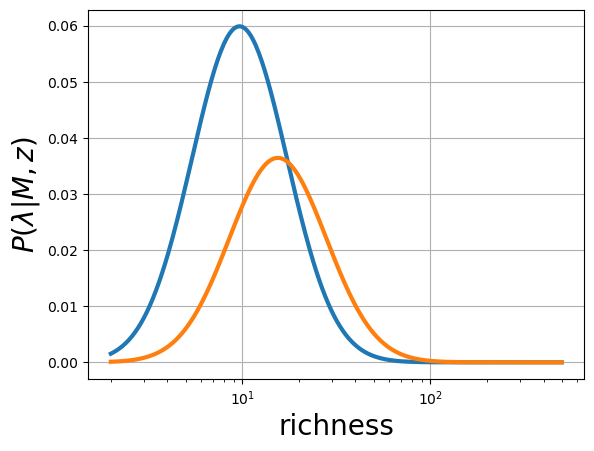

In [8]:
plt.plot(richness_grid, rm_relation.pdf_richness_mass_relation(richness_grid, 14, .4, theta_rm), linewidth=3)
plt.plot(richness_grid, rm_relation.pdf_richness_mass_relation(richness_grid, 14.2, .4, theta_rm), linewidth=3)
plt.xlabel('richness', fontsize=20)
plt.ylabel(r'$P(\lambda|M, z)$', fontsize=20)
plt.grid(True)
plt.xscale('log')

# Cluster Abundance

In [9]:
z_edges = np.linspace(0.1, 1, 4)
Z_bin = binning(z_edges)
richness_edges = np.exp(np.linspace(np.log(20), np.log(200), 5))
Richness_bin = binning(richness_edges)

## effect of purity and completeness

In [10]:
bins = {'redshift_bins':Z_bin, 'richness_bins': Richness_bin}
grids = {'logm_grid': logm_grid, 'z_grid': z_grid, 'richness_grid':richness_grid}
count_modelling = {'dNdzdlogMdOmega':None,'richness_mass_relation':None, 'completeness':None, 'purity':None }
params = {'params_purity':theta_purity, 'params_completeness': theta_completeness, 'params_richness_mass_relation': theta_rm,
         'CCL_cosmology': cosmo, 'halo_mass_distribution': hmd}
adds = {'add_purity' : True, 'add_completeness':True}
compute = {'compute_dNdzdlogMdOmega':True,'compute_richness_mass_relation':True, 'compute_completeness':True, 'compute_purity':True }

In [11]:
#compute_count_modeling
%time count_modelling_new = cl_count.recompute_count_modelling(count_modelling, grids = grids, compute = compute, params = params)

CPU times: user 4.35 s, sys: 721 ms, total: 5.07 s
Wall time: 5.07 s


In [12]:
print(count_modelling_new.keys())
print(compute)

dict_keys(['dNdzdlogMdOmega', 'richness_mass_relation', 'completeness', 'purity', 'richness_mass_relation - mean', 'richness_mass_relation - sigma'])
{'compute_dNdzdlogMdOmega': True, 'compute_richness_mass_relation': True, 'compute_completeness': True, 'compute_purity': True}


In [13]:
#define integrand
integrand_count = cl_count.define_count_integrand(count_modelling_new, adds)

In [14]:
Omega = (4*np.pi)
N = Omega * cl_count.Cluster_SurfaceDensity_ProxyZ(bins, integrand_count = integrand_count, grids = grids)
    #add.append(simps(p0, logm_grid, axis=1))

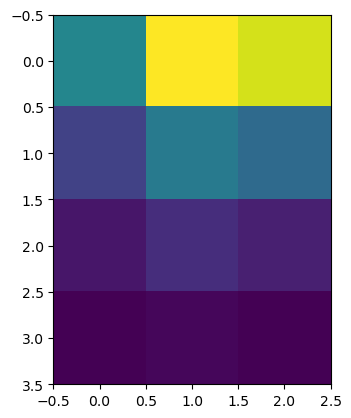

In [15]:
plt.imshow(N)

In [16]:
adds1 = {'add_purity' : False, 'add_completeness':False}
adds2 = {'add_purity' : True, 'add_completeness':False}
adds3 = {'add_purity' : False, 'add_completeness':True}
adds4 = {'add_purity' : True, 'add_completeness':True}
adds_list = [adds1, adds2, adds3, adds4]
list_dNdlambda = []
for adds in adds_list:
    integrand_count = cl_count.define_count_integrand(count_modelling_new, adds)
    list_dNdlambda.append(simps(integrand_count, logm_grid, axis=1))

In [17]:
len(z_grid)

302

In [18]:
len(z_grid)

302

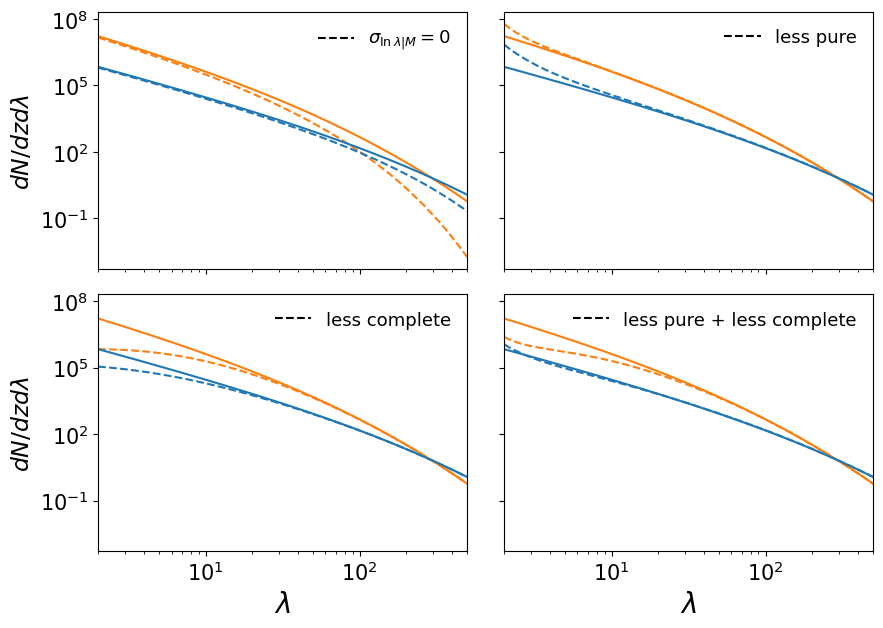

In [22]:
fig, ax = plt.subplots(2,2, figsize=(10,7), sharex=True, sharey=True, )
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
fmt = ['-', '-', '-', '-']
p0m = hmf.dndlog10M(logm_grid, z_grid[299], cosmo, hmd)*hmf.dVdzdOmega(z_grid[299], cosmo)
log10Mlambda = log10m0 + np.log(richness_grid/np.exp(proxy_mu0))/proxy_mulog10m + (proxy_muz/proxy_mulog10m) * np.log((1+z_grid[299])/(1 + z0))
newhmf = np.interp(log10Mlambda, logm_grid, p0m)

ax[0,0].plot(richness_grid, Omega*newhmf/(proxy_mulog10m*richness_grid), '--C1')
ax[0,1].plot(richness_grid, Omega*list_dNdlambda[1][:,299], '--C1')
ax[1,0].plot(richness_grid, Omega*list_dNdlambda[2][:,299], '--C1')
ax[1,1].plot(richness_grid, Omega*list_dNdlambda[3][:,299], '--C1')

ax[0,0].plot([], [], '--k', label = r'$\sigma_{\ln\lambda|M} = 0$')
ax[0,1].plot([], [], '--k',  label = 'less pure')
ax[1,0].plot([], [], '--k',  label = 'less complete')
ax[1,1].plot([], [], '--k', label = 'less pure + less complete')



p0m = hmf.dndlog10M(logm_grid, z_grid[0], cosmo, hmd)*hmf.dVdzdOmega(z_grid[0], cosmo)
log10Mlambda = log10m0 + np.log(richness_grid/np.exp(proxy_mu0))/proxy_mulog10m + (proxy_muz/proxy_mulog10m) * np.log((1+z_grid[0])/(1 + z0))
newhmf = np.interp(log10Mlambda, logm_grid, p0m)

ax[0,0].plot(richness_grid, Omega*newhmf/(proxy_mulog10m*richness_grid), '--C0')
ax[0,1].plot(richness_grid, Omega*list_dNdlambda[1][:,0], '--C0',  )
ax[1,0].plot(richness_grid, Omega*list_dNdlambda[2][:,0], '--C0', )
ax[1,1].plot(richness_grid, Omega*list_dNdlambda[3][:,0], '--C0', )
plt.loglog()
for i in range(2):
    for j in range(2):
        ax[i,j].plot(richness_grid, Omega*list_dNdlambda[0][:,299], '-C1')
        ax[i,j].plot(richness_grid, Omega*list_dNdlambda[0][:,0], '-C0')
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].set_xlim(min(richness_grid), max(richness_grid))
       # ax[i,j].set_ylim(1e-1, 1e9)
        ax[i,j].legend(frameon=False, fontsize=13, loc = 'upper right')
        if j ==0:
            ax[i,j].set_ylabel(f'$dN/dzd\lambda$', fontsize=17)
        if i ==1:
            ax[i,j].set_xlabel('$\lambda$', fontsize=20)
        ax[i,j].tick_params(axis='both', which="both", labelsize= 15)
#plt.tick_params(axis='both', which="both", labelsize= 20)
plt.savefig('hlambdaf.png', bbox_inches='tight', dpi=300)

# Effect of mass-concentration relation

In [70]:
#cluster lensing
r = np.logspace(np.log10(.1), np.log10(10),10)
cluster_lensing_1 = cl_lensing.compute_cluster_lensing(r, 'Duffy08', logm_grid, z_grid, cosmo, cosmo_clmm)
cluster_lensing_2 = cl_lensing.compute_cluster_lensing(r, 'Diemer15', logm_grid, z_grid, cosmo, cosmo_clmm)
cluster_lensing_3 = cl_lensing.compute_cluster_lensing(r, 'Prada12', logm_grid, z_grid, cosmo, cosmo_clmm)

In [71]:
NDS_profiles_Duffy = Omega * cl_lensing.Cluster_dNd0mega_Lensing_ProxyZ(bins, integrand_count = integrand_count, cluster_lensing = cluster_lensing_1, lensing_radius = r, grids = grids)
DS_profiles_Duffy = NDS_profiles_Duffy/N

In [72]:
NDS_profiles_Diemer = Omega * cl_lensing.Cluster_dNd0mega_Lensing_ProxyZ(bins, integrand_count = integrand_count, cluster_lensing = cluster_lensing_2, lensing_radius = r, grids = grids)
DS_profiles_Diemer = NDS_profiles_Diemer/N

In [73]:
NDS_profiles_Prada = Omega * cl_lensing.Cluster_dNd0mega_Lensing_ProxyZ(bins, integrand_count = integrand_count, cluster_lensing = cluster_lensing_3, lensing_radius = r, grids = grids)
DS_profiles_Prada = NDS_profiles_Prada/N

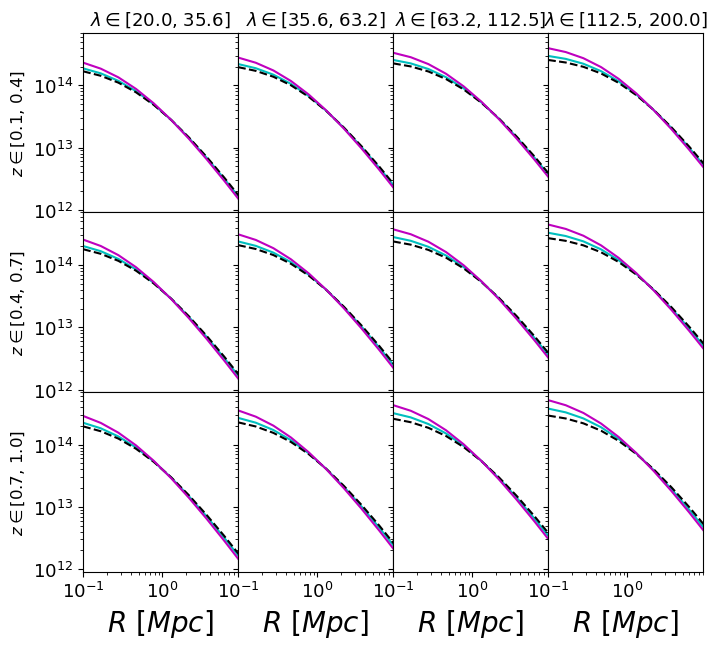

In [74]:
fig, ax = plt.subplots( len(Z_bin), len(Richness_bin), figsize = (8, 7), sharey=True, sharex = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
for i in range(len(Z_bin)):
    for j in range(len(Richness_bin)):
        label_z =  r'$ z \in $' + f'[{Z_bin[i][0]:.1f}, {Z_bin[i][1]:.1f}]'
        label_l = r'$ \lambda \in $' + f'[{Richness_bin[j][0]:.1f}, {Richness_bin[j][1]:.1f}]'
        ax[i,j].loglog(r, DS_profiles_Diemer[:,j,i], '-c')
        ax[i,j].loglog(r, DS_profiles_Duffy[:,j,i], '--k')
        ax[i,j].loglog(r, DS_profiles_Prada[:,j,i], '-m')
        ax[i,j].set_xlabel(r'$R\ [Mpc]$', fontsize=20)
        ax[i,0].set_ylabel(r'$\Delta\Sigma$', fontsize=20)
        ax[i,j].tick_params(axis='both', which="both", labelsize= 13)
        ax[i,j].set_xlim(.1, 9)
        ax[i, 0].set_ylabel(label_z, fontsize = 12)
        ax[0, j].set_title(label_l, fontsize = 13)
plt.savefig('hlambdaf_ds.png', bbox_inches='tight', dpi=300)

In [159]:
NM = Omega * cl_mass.Cluster_dNd0mega_Mass_ProxyZ(bins, integrand_count = integrand_count, grids = grids)

In [161]:
M = NM/N

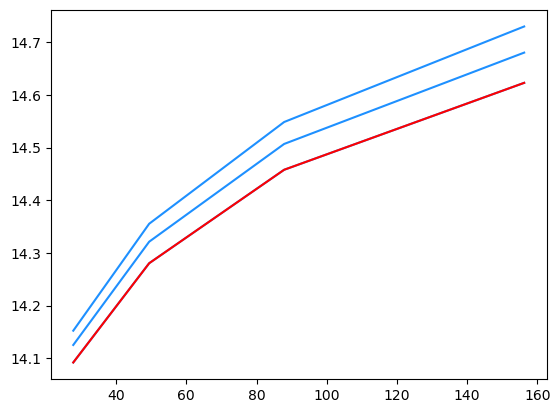

In [164]:
#for i, r in enumerate(Richness_bin):
for j, z in enumerate(Z_bin):
        plt.plot(np.mean(Richness_bin, axis=1), np.log10(M[:,j]), c='dodgerblue')
plt.plot(np.mean(Richness_bin, axis=1), np.log10(M[:,j]), c='red')
        